## Modeling scRNA-seq using sequence features and a custom kNN graph

In this tutorial we demonstrate the applicability of mubind in a case where an arbitrarily complex graph is provided.
The dataset is mouse pancreatic endocrinogenesis multiome [Klein et al 2023]


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
!readlink -f .

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


In [4]:
import pandas as pd
import numpy as np
import os
import seaborn
import itertools
import glob

import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [5]:
# these are motifs used during training (pre-weights)
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

# motifs loaded 2179


286

In [6]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [7]:

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [8]:

import mubind as mb
import numpy as np
import pandas as pd
import torch
# mb.models.Mubind
import torch
import torch
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle


# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [9]:
device = 'cpu'

In [10]:
import scanpy as sc

In [11]:
ad_path = '../../../data/organoids_treutlein_dataset/all_velo_stoch_2000f.h5ad'
os.path.exists(ad_path)

True

In [12]:
# pybiomart is requred
annot = sc.queries.biomart_annotations(
    "hsapiens",
    ["ensembl_gene_id", "start_position", "end_position", "chromosome_name", "external_gene_name"],
).set_index("external_gene_name")


In [13]:
tss_path = os.path.join(bd.constants.ANNOTATIONS_DIRECTORY, 'hg38', 'genome', 'TSS.in')
print(os.path.exists(tss_path), tss_path)
tss = pd.read_csv(tss_path, sep='\t', header=None)
tss.columns = ['chrom', 'pos', 'strand', 'symbol']
tss = tss.set_index('symbol')
tss = tss[~tss.index.duplicated(keep='first')]

True annotations/hg38/genome/TSS.in


In [14]:
# annot = annot[~annot.index.duplicated(keep='first')]

In [15]:
# load the pancreas multiome dataset
rna = sc.read_h5ad(ad_path)
# rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')

In [16]:
## preprocessing to convert the relevant counts 

In [17]:
rna.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'n_cells_RNA',
       'n_cells_ATAC', 'line', 'age', 'nCount_peaks', 'nFeature_peaks',
       'S.Score', 'G2M.Score', 'Phase', 'nowakowski_prediction',
       'RNA_snn_res.1', 'seurat_clusters', 'glyc_cluster', 'nCount_css',
       'nFeature_css', 'RNA_snn_res.0.8', 'DF', 'MH', 'VF', 'X1', 'pred_class',
       'ac_pole', 'antihem', 'cortical_hem', 'hindbrain_floor_plate',
       'hindbrain_roof_plate', 'hypothalamic_floor_plate', 'isthmus',
       'midbrain_basal_plate', 'midbrain_floor_plate', 'roof_plate',
       'telencephalic_roof_plate', 'zona_limitans', 'pred_region',
       'RNA_snn_res.2', 'patterning_region', 'n_counts',
       'velocity_self_transition', 'neuron_type', 'terminal_states',
       'terminal_states_probs', 'to_terminal_states_dp', 'clusters_gradients',
       'to_ctx', 'to_nt', 'to_ge', 'velocity_pseudotime', 'to_nt_ranks',
       'to_ge_ranks', 'to_ctx_ranks', 'is_root'],
      dtype='object')

In [18]:
rna_raw = rna.raw.to_adata()

In [19]:
import scvelo as scv

In [20]:
rna_raw.obs['velocity_pseudotime'] = rna.obs['velocity_pseudotime']

In [21]:
rna_raw.obs['velocity_pseudotime']

ATAC_RNA_DAY11_SJ_AAACCCAAGTCGTTAC-1    0.722959
ATAC_RNA_DAY11_SJ_AAACCCAGTAGCGAGT-1    0.415957
ATAC_RNA_DAY11_SJ_AAACCCAGTGACTGAG-1    0.581129
ATAC_RNA_DAY11_SJ_AAACGAAAGAAGCCAC-1    0.705269
ATAC_RNA_DAY11_SJ_AAACGAATCTGCTGAA-1    0.699266
                                          ...   
RNA_ATAC_DAY61_SJ_TTTGGTTAGGAAGAAC-1    0.775871
RNA_ATAC_DAY61_SJ_TTTGGTTGTCTGGATT-1    0.819001
RNA_ATAC_DAY61_SJ_TTTGGTTTCTGAGTAC-1    0.945245
RNA_ATAC_DAY61_SJ_TTTGTGTGTCAATCCA-1    0.890183
RNA_ATAC_DAY61_SJ_TTTGTGTTCGCGATGC-1    0.821269
Name: velocity_pseudotime, Length: 34088, dtype: float64

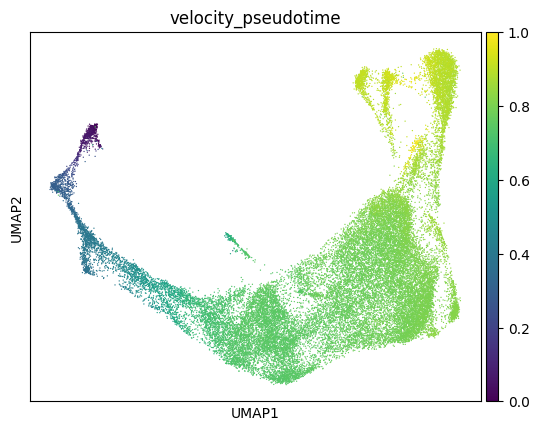

In [22]:
sc.pl.umap(rna_raw, color='velocity_pseudotime')

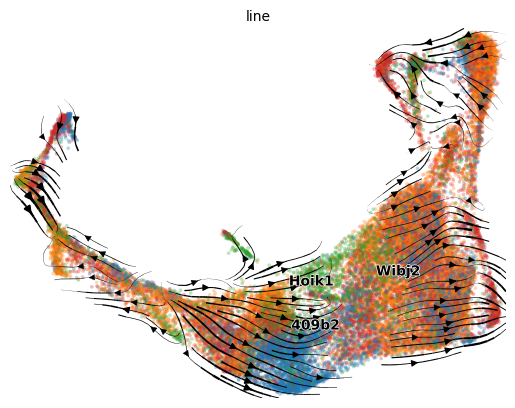

In [23]:
scv.pl.velocity_embedding_stream(rna_raw, color='line')

In [24]:
rna = rna_raw.copy()

In [25]:
rna.var

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable
MIR1302-2HG,0.000296,0.000296,0.000415,0.711770,0
FAM138A,0.000000,0.000000,0.000000,0.000000,0
OR4F5,0.000000,0.000000,0.000000,0.000000,0
AL627309.1,0.005566,0.007686,0.011725,0.655527,0
AL627309.3,0.000726,0.000887,0.001214,0.730368,0
...,...,...,...,...,...
AC233755.2,0.000000,0.000000,0.000000,0.000000,0
AC233755.1,0.000000,0.000000,0.000000,0.000000,0
AC240274.1,0.419682,2.546358,1.383846,1.840058,0
AC213203.1,0.000000,0.000000,0.000000,0.000000,0


In [26]:
rna.var[tss.columns] = tss

In [27]:
rna = rna[:,~pd.isnull(rna.var['pos'])].copy()


In [28]:
rna.shape

(34088, 20070)

In [29]:
rna.var['tss_start'] = rna.var['pos'].astype(int)
rna = rna[:,~pd.isnull(rna.var['tss_start'])]
bp = 250
tss_start = rna.var['tss_start'].astype(int)
rna.var['tss_start'] = np.where(rna.var['strand'] == '+', tss_start - bp, tss_start)
rna.var['tss_end'] = np.where(rna.var['strand'] == '+', tss_start, tss_start + bp)

rna.var['chromosome_name'] = rna.var['chrom']
rna.var['k'] = rna.var['chromosome_name'].astype(str) + ':' + rna.var['tss_start'].astype(str) + '-' + rna.var['tss_end'].astype(str)

In [30]:
# rna.shape, atac.shape
# atac_path = '../../../annotations/scatac/noack_et_al_velocity_graph.h5ad'
# os.path.exists(atac_path)
# ad = sc.read_h5ad(atac_path)

In [31]:
ad = rna

In [32]:
ad.var_names

Index(['OR4F5', 'OR4F29', 'OR4F16', 'FAM87B', 'LINC00115', 'FAM41C', 'SAMD11',
       'NOC2L', 'KLHL17', 'PLEKHN1',
       ...
       'SPATC1L', 'LSS', 'MCM3AP-AS1', 'MCM3AP', 'YBEY', 'C21orf58', 'PCNT',
       'DIP2A', 'S100B', 'PRMT2'],
      dtype='object', length=20070)

In [33]:
ad

AnnData object with n_obs × n_vars = 34088 × 20070
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'n_cells_RNA', 'n_cells_ATAC', 'line', 'age', 'nCount_peaks', 'nFeature_peaks', 'S.Score', 'G2M.Score', 'Phase', 'nowakowski_prediction', 'RNA_snn_res.1', 'seurat_clusters', 'glyc_cluster', 'nCount_css', 'nFeature_css', 'RNA_snn_res.0.8', 'DF', 'MH', 'VF', 'X1', 'pred_class', 'ac_pole', 'antihem', 'cortical_hem', 'hindbrain_floor_plate', 'hindbrain_roof_plate', 'hypothalamic_floor_plate', 'isthmus', 'midbrain_basal_plate', 'midbrain_floor_plate', 'roof_plate', 'telencephalic_roof_plate', 'zona_limitans', 'pred_region', 'RNA_snn_res.2', 'patterning_region', 'n_counts', 'velocity_self_transition', 'neuron_type', 'terminal_states', 'terminal_states_probs', 'to_terminal_states_dp', 'clusters_gradients', 'to_ctx', 'to_nt', 'to_ge', 'velocity_pseudotime', 'to_nt_ranks', 'to_ge_ranks', 'to_ctx_ranks', 'is_root'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.var

In [34]:
# if rapids is available, use it
# import rapids_singlecell as rapids
# rapids.pp.neighbors(rna)

# if rapids is not avaible, default scanpy
# sc.pp.neighbors(rna)


In [35]:
rna.obs

,orig.ident,nCount_RNA,nFeature_RNA,sample,n_cells_RNA,n_cells_ATAC,line,age,nCount_peaks,nFeature_peaks,...,to_terminal_states_dp,clusters_gradients,to_ctx,to_nt,to_ge,velocity_pseudotime,to_nt_ranks,to_ge_ranks,to_ctx_ranks,is_root
ATAC_RNA_DAY11_SJ_AAACCCAAGTCGTTAC-1,0,38920.375092,4238,H9_11,1,3,H9,11.0,40748.250000,34555,...,1.069666,ctx_ex,0.439175,0.221900,0.338925,0.722959,0.931562,0.113383,0.288054,False
ATAC_RNA_DAY11_SJ_AAACCCAGTAGCGAGT-1,0,95691.969963,6444,Wibj2_11,1,3,Wibj2,11.0,41700.250000,34018,...,1.071203,ctx_ex,0.442508,0.208965,0.348526,0.415957,0.821498,0.234159,0.392283,False
ATAC_RNA_DAY11_SJ_AAACCCAGTGACTGAG-1,0,59839.839377,6389,Wibj2_11,1,2,Wibj2,11.0,42299.416667,36387,...,1.069724,ctx_ex,0.443078,0.206821,0.350101,0.581129,0.769144,0.295764,0.435545,False
ATAC_RNA_DAY11_SJ_AAACGAAAGAAGCCAC-1,0,42407.541525,5511,H9_11,1,2,H9,11.0,41551.583333,36119,...,1.069497,ctx_ex,0.439281,0.212382,0.348337,0.705269,0.891224,0.213448,0.289416,False
ATAC_RNA_DAY11_SJ_AAACGAATCTGCTGAA-1,0,66252.810140,5486,Wibj2_11,1,3,Wibj2,11.0,48602.500000,39830,...,1.069608,ctx_ex,0.439642,0.217163,0.343195,0.699266,0.916587,0.145095,0.295131,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RNA_ATAC_DAY61_SJ_TTTGGTTAGGAAGAAC-1,1,24428.074731,6114,Wibj2_61,2,1,Wibj2,61.0,60649.833333,23155,...,1.065365,ctx_ex,0.458676,0.206112,0.335212,0.775871,0.758431,0.094491,0.771242,False
RNA_ATAC_DAY61_SJ_TTTGGTTGTCTGGATT-1,1,22890.030078,5913,409b2_61,2,1,409b2,61.0,58058.500000,23562,...,1.060034,ctx_ex,0.479395,0.179083,0.341522,0.819001,0.486897,0.137145,0.962113,False
RNA_ATAC_DAY61_SJ_TTTGGTTTCTGAGTAC-1,1,11461.793681,3306,Wibj2_61,1,1,Wibj2,61.0,13787.250000,13229,...,0.000000,mesen_ex,0.000000,1.000000,0.000000,0.945245,1.000000,0.018086,0.052381,False
RNA_ATAC_DAY61_SJ_TTTGTGTGTCAATCCA-1,1,15871.110440,4877,Hoik1_61,2,1,Hoik1,61.0,41336.666667,19151,...,0.000000,ge_in,0.000000,0.000000,1.000000,0.890183,0.052886,0.956891,0.052381,False


In [36]:
rna.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'n_cells_RNA',
       'n_cells_ATAC', 'line', 'age', 'nCount_peaks', 'nFeature_peaks',
       'S.Score', 'G2M.Score', 'Phase', 'nowakowski_prediction',
       'RNA_snn_res.1', 'seurat_clusters', 'glyc_cluster', 'nCount_css',
       'nFeature_css', 'RNA_snn_res.0.8', 'DF', 'MH', 'VF', 'X1', 'pred_class',
       'ac_pole', 'antihem', 'cortical_hem', 'hindbrain_floor_plate',
       'hindbrain_roof_plate', 'hypothalamic_floor_plate', 'isthmus',
       'midbrain_basal_plate', 'midbrain_floor_plate', 'roof_plate',
       'telencephalic_roof_plate', 'zona_limitans', 'pred_region',
       'RNA_snn_res.2', 'patterning_region', 'n_counts',
       'velocity_self_transition', 'neuron_type', 'terminal_states',
       'terminal_states_probs', 'to_terminal_states_dp', 'clusters_gradients',
       'to_ctx', 'to_nt', 'to_ge', 'velocity_pseudotime', 'to_nt_ranks',
       'to_ge_ranks', 'to_ctx_ranks', 'is_root'],
      dtype='object')

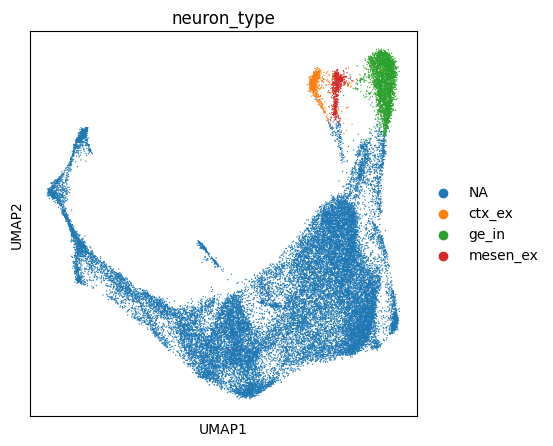

In [37]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 5

# RNA
sc.pl.umap(rna, color='neuron_type')

#ATAC
# sc.pl.umap(atac, color='celltype')

In [38]:
rna

AnnData object with n_obs × n_vars = 34088 × 20070
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'n_cells_RNA', 'n_cells_ATAC', 'line', 'age', 'nCount_peaks', 'nFeature_peaks', 'S.Score', 'G2M.Score', 'Phase', 'nowakowski_prediction', 'RNA_snn_res.1', 'seurat_clusters', 'glyc_cluster', 'nCount_css', 'nFeature_css', 'RNA_snn_res.0.8', 'DF', 'MH', 'VF', 'X1', 'pred_class', 'ac_pole', 'antihem', 'cortical_hem', 'hindbrain_floor_plate', 'hindbrain_roof_plate', 'hypothalamic_floor_plate', 'isthmus', 'midbrain_basal_plate', 'midbrain_floor_plate', 'roof_plate', 'telencephalic_roof_plate', 'zona_limitans', 'pred_region', 'RNA_snn_res.2', 'patterning_region', 'n_counts', 'velocity_self_transition', 'neuron_type', 'terminal_states', 'terminal_states_probs', 'to_terminal_states_dp', 'clusters_gradients', 'to_ctx', 'to_nt', 'to_ge', 'velocity_pseudotime', 'to_nt_ranks', 'to_ge_ranks', 'to_ctx_ranks', 'is_root'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.var

In [39]:
# scv.pl.velocity_embedding_stream(rna, color='celltype')

(array([ 288.,  302.,  334.,  298.,  332.,  298.,  317.,  335.,  306.,
         318.,  329.,  338.,  323.,  306.,  330.,  314.,  315.,  330.,
         351.,  357.,  334.,  328.,  354.,  371.,  365.,  384.,  377.,
         391.,  440.,  416.,  489.,  566.,  695.,  961., 7178.]),
 array([0.        , 0.01428571, 0.02857143, 0.04285714, 0.05714286,
        0.07142857, 0.08571429, 0.1       , 0.11428571, 0.12857143,
        0.14285714, 0.15714286, 0.17142857, 0.18571429, 0.2       ,
        0.21428571, 0.22857143, 0.24285714, 0.25714286, 0.27142857,
        0.28571429, 0.3       , 0.31428571, 0.32857143, 0.34285714,
        0.35714286, 0.37142857, 0.38571429, 0.4       , 0.41428571,
        0.42857143, 0.44285714, 0.45714286, 0.47142857, 0.48571429,
        0.5       ]),
 <BarContainer object of 35 artists>)

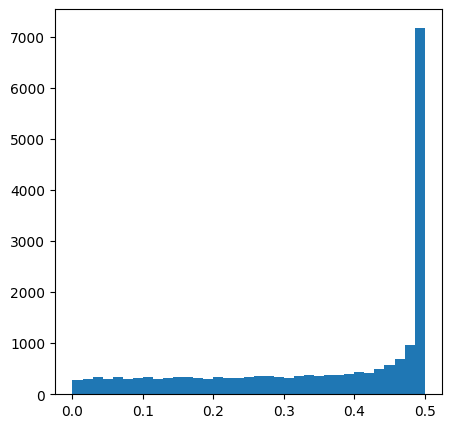

In [40]:
acc = (rna.X != 0).sum(axis=0) / rna.shape[0]
acc_score = abs(.5 - acc)
rna.var['acc_score'] = acc_score.A.T
rna.var['acc_score_rank'] = rna.var['acc_score'].rank(ascending=False)
plt.hist(rna.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [41]:
# n_sample_cells = 750
# n_sample_peaks = 1500

In [42]:
rna.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'n_cells_RNA',
       'n_cells_ATAC', 'line', 'age', 'nCount_peaks', 'nFeature_peaks',
       'S.Score', 'G2M.Score', 'Phase', 'nowakowski_prediction',
       'RNA_snn_res.1', 'seurat_clusters', 'glyc_cluster', 'nCount_css',
       'nFeature_css', 'RNA_snn_res.0.8', 'DF', 'MH', 'VF', 'X1', 'pred_class',
       'ac_pole', 'antihem', 'cortical_hem', 'hindbrain_floor_plate',
       'hindbrain_roof_plate', 'hypothalamic_floor_plate', 'isthmus',
       'midbrain_basal_plate', 'midbrain_floor_plate', 'roof_plate',
       'telencephalic_roof_plate', 'zona_limitans', 'pred_region',
       'RNA_snn_res.2', 'patterning_region', 'n_counts',
       'velocity_self_transition', 'neuron_type', 'terminal_states',
       'terminal_states_probs', 'to_terminal_states_dp', 'clusters_gradients',
       'to_ctx', 'to_nt', 'to_ge', 'velocity_pseudotime', 'to_nt_ranks',
       'to_ge_ranks', 'to_ctx_ranks', 'is_root'],
      dtype='object')

In [43]:
n_cell_types = len(set(rna.obs['neuron_type']))

In [44]:
n_cell_types

4

In [45]:
rna.shape

(34088, 20070)

In [46]:
rna.obs['neuron_type'].value_counts()

neuron_type
NA          29918
ge_in        2938
ctx_ex        634
mesen_ex      598
Name: count, dtype: int64

In [47]:
rna.shape

(34088, 20070)

In [48]:
 # int(n_sample_cells * 1.5)
n_select = rna.shape[0] # 500
n_sample_cells = n_select
n_sample_peaks = rna.shape[1]
# n_select =  int(n_sample_cells / n_cell_types) # bug if > 20
obs_sample = rna.obs.groupby('neuron_type').sample(n_select, random_state=n_sample_cells, replace=True).index.drop_duplicates()
var_sample = pd.Series(rna.var_names).sample(n_sample_peaks, random_state=n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = rna[rna.obs_names.isin(obs_sample),rna.var_names.isin(var_sample)].copy()
rna.shape, ad.shape

((34088, 20070), (24520, 20070))

In [49]:
n_sample_peaks

20070

In [50]:
ad.obs['neuron_type'].value_counts()

neuron_type
NA          20350
ge_in        2938
ctx_ex        634
mesen_ex      598
Name: count, dtype: int64

In [51]:

# ad.uns['velocity_graph'] = rna_sample.uns['velocity_graph']
# # ad.layers['velocity'] = rna_sample.layers['velocity']
# ad.uns['velocity_graph'].shape



In [52]:

rna_sample = rna[ad.obs_names]

mask = rna.obs_names.isin(rna_sample.obs_names)

# local one step transposition to finalize processing
vgraph = rna.uns['velocity_graph']
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph.shape

(24520, 24520)

In [53]:
# pip install scvelo

In [54]:
# the scvelo package is a condition to explore the vector stream visualization. Not priority
import scvelo as scv

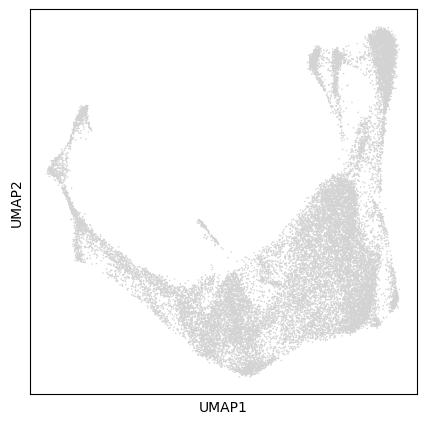

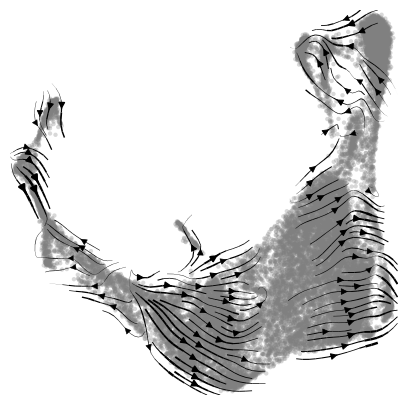

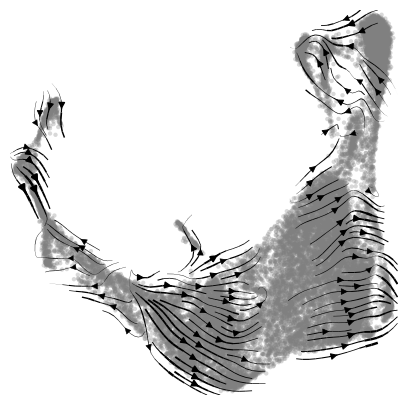

In [55]:

rna_sample.uns['velocity_graph'] = vgraph
try:
# atac
    sc.pl.umap(ad)

    # rna
    # append the estimated velocities to the sample adata
    scv.pl.velocity_embedding_stream(rna_sample)

    scv.pl.velocity_embedding_stream(rna_sample)
    rna_sample.shape
except Exception:
    print('sample too small to plot graph')


In [56]:
# ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
# ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
# ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

# print('features by chromosome')
# extend = 50
# ad.var['chr'].value_counts()

In [57]:
# ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
# ad.var['summit.start'] = ad.var['summit'] - extend
# ad.var['summit.end'] = ad.var['summit'] + extend
# ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)
ad.var['chr'] = ad.var['chrom'].astype(str)
ad.var['summit.start'] = ad.var['tss_start'].astype(str)
ad.var['summit.end'] = ad.var['tss_end'].astype(str)
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [58]:
# remove chromosome duplicates
dups = (ad.var['k.summit'].value_counts() > 1)
dups = dups[dups].index
ad = ad[:,~ad.var['k.summit'].isin(dups)]

In [59]:
n_seqs = ad.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='hg38', uppercase=True,
                                            gen_path='annotations/hg38/genome/hg38.fa',
                                            bin='/home/ilibarra/miniconda3/envs/mubind/bin/bedtools')
                                            # bin='/home/ilibarra/.conda/envs/mubind/bin/bedtools')
                                            # gen_path='../../../annotations/hg38/genome/hg38.fa')

keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

/tmp/tmpae4o29wh
genome hg38 False
annotations/hg38/genome/hg38.fa
True annotations/hg38/genome/hg38.fa
running bedtools...
['/home/ilibarra/miniconda3/envs/mubind/bin/bedtools', 'getfasta', '-fi', 'annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmpae4o29wh', '-fo', '/tmp/tmpy6iw2303']
/home/ilibarra/miniconda3/envs/mubind/bin/bedtools getfasta -fi annotations/hg38/genome/hg38.fa -bed /tmp/tmpae4o29wh -fo /tmp/tmpy6iw2303


19883

In [60]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [61]:
ad.shape, counts.shape

((24520, 19883), (19883, 24520))

In [62]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [63]:
counts.shape, next_data.shape

((19883, 24520), (19883, 24520))

In [64]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [65]:
next_data.shape, ad.shape

((19883, 24521), (24520, 19883))

In [66]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(19883, 24521)

In [67]:
next_data = next_data[~next_data.index.str.contains('N')]
next_data.shape

(19882, 24521)

In [68]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [69]:
n_cells = ad.shape[0] # next_data.shape[1]
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [70]:
next_data.shape, ad.shape

((19882, 24521), (24520, 19883))

In [71]:
n_cells

24520

In [72]:
ad.shape

(24520, 19883)

In [73]:
# next_data.index

In [74]:
ad.shape

(24520, 19883)

In [75]:
next_data = next_data[~next_data.index.duplicated(keep='first')]

In [76]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)
next_data_sel.shape

(19882, 24521)

In [77]:
next_data_sel

,0,1,2,3,4,5,6,7,8,9,...,24511,24512,24513,24514,24515,24516,24517,24518,24519,var
seq,,,,,,,,,,,,,,,,,,,,,
GTTAGGGCGGGGCGCGCGTGCGCAGTCACGCGCTGCGCCAACCGCCACAGCTCCGGGAAGGCGGCCAGGACCGGCTAGAGCCGGTTAGAACCAGTGGCGCCCGCCCACGAGCCAGCGCCTCACAAAGGGAGGGCGGCTCACGGCCCTCGCGTATCCCTGCGCGGCGCTCGCGAGCCGCCCCTCCCCCGGCGTTTGTCCCTGACGCAGCCCCACCGGTTGCGCAGTCCCTCCCCGCCCCCGCTCTCCCCTC,660.0,258.0,2130.0,708.000000,2049.0,684.000000,1422.00,302.000000,1596.0,756.0,...,396.0,695.0,1231.0,860.0,1629.0,919.0,450.0,778.0,1564.0,642108.315082
AACGTTCACGGCGACTACTGCACTTATATACGGTTCTCCCCCACCCTCGGGAAAAAGGCGGAGCCAGTACACGACATCACTTTCCCAGTTTACCCCGCGCCACCTTCTCTAGGCACCGGTTCAATTGCCGACCCCTCCCCCCAACTTCTCGGGGACTGTGGGCGATGTGCGCTCTGCCCACTGACGGGCACCGGAGCCTCACGCATGCTCTTCTCCACCTCAGTGATGACGAGAGCGGGCGGGTGAGGGG,1290.0,699.0,1090.0,884.000000,1086.0,978.000000,873.00,708.000000,868.0,669.0,...,91.0,204.0,375.0,270.0,324.0,146.0,155.0,138.0,292.0,97205.069858
AACGAGACCTACTGGGAAGCAGCTTTTATAGCACGCCAAGCGCCGCGAGATCTCCGCAGCCCCGCCCCAAGCGGGAGCGGGCCGAGCTCCTATAAGACAACCTGTGATTGGCTCCGCGGTGCCCCGCCCTCACCGGGCTCTGAGTGCTCTTGCCCGTCCGGCCCCAGCCGCGGCCCGGGAATCTACGTCACCCGAAAAGCGACTATAAACGCCGGCGCCTCCGTCCCCAGCCGCGGCTCGGGAATCCACC,786.0,576.0,762.0,554.000000,693.0,642.000000,600.00,450.000000,564.0,543.0,...,20.0,117.0,210.0,60.0,142.0,86.0,56.0,39.0,156.0,39294.151620
CCAACGGAGGCGAAGTCCGAATACCTAGGCAACCCTAACCTAAAAGTGTTTTTAACGTTCTCAGGTCCTATAATTTACCCAAATAAAGTGGGACCGTATTTGCAGGCGCTGAGAAACTTTCTCAACAGTAAGAACCAATCAGGCGCAGTGCGCAGGCGCCTTCAGTGGGTCCTGGGTCCGCCTCTTCCGCCCGGTGCGGGCGCCGATTGGTCCGCGTGGACACATAAGAGGCTGCGTATAGGCGCGAGAG,36.5,49.0,119.2,34.142857,60.3,44.307692,95.25,26.714286,45.0,41.7,...,18.0,128.0,189.0,67.0,97.0,67.0,68.0,33.0,118.0,35222.859110
GACAGGACTCGGCCGCGGCCCGCGCAGCGGCTGAAGCGCCGGGGCAGTAACGGCGGACGTCAAGCAAGTCCGGCCGTCGGTTACTCAGGGCCCAGGAATCACGGCCGCCCCGCCGCATTCTCAGCGGCAACATGTCTGCGACGGCGGCCCTAGGGCTGCCGGGAGAGCCGCGGCGACGTCAGTTCCTCCTTTCGGGGCTCTGATTGGTCAGAGCGCCCGGCGCTTCTGGTTGGCCGGCCCTGCTATCATC,414.0,291.0,404.0,440.000000,513.0,456.000000,369.00,278.000000,470.0,342.0,...,25.0,101.0,196.0,100.0,133.0,87.0,76.0,29.0,163.0,24023.941505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AATTGTGTCTCATATGCATAATCATGACCAATGCGAATGGGATTACCATTGACTTAAGCCAATTATGACGTCCCCCTGGGCCTAGGGTAGGACTCCACTCCCCTGCAACACACGATCCTCTGAACAAAACTGAGGTTCTTCTAGCAAGGAGAAGACAGGGAGAATGACTATCAGTTAGTCAATCAGAAGTATCCACCATACTCCGCAAATTGCTTATCTTTTTTGGCTTTAGTATTTTCATGTGTAAAAT,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
GATCGCCAGTCAGGCAAAACGGAAGCTTCTGAAACCAGGAAGTGGACGGGAAGCCAGTTTGGCCAGTGGGATACTGCTGGTTTTGAGAACGAGGAACAGAAACTGAAATTTCTCAAACTTACGGGTGGCTTCAAAAACTTGTCCCCTTCGATTAGCCCCCACCCCCACCCCCACCCTCCCGCCCCACCCAGCCCGATTGCAAGGTCCAACGTGGCCCTCAGTAAGAAGGTGGCCGACAGTCTGCAGCAGA,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AGGGTAATTATACTTTTTACTGACAATAGTGGCTCCAAGCCAAGCACAAGCTTTCATGGGTGATTACCTAATGCACCTCACATGGAATGGTTACATAATGTGTGGAGGGGTTGTGTGCCCGCACTCCAAAGCTGCTGAGTCATGCTGCACCAAAAGGCTGCCTTGGCCTACTCCTGACGGAAGTGCAACCATTTCCCTCACAGGTGGGAATGAACAATTGAAAAAAATAATACAATTTACTATATTAAGG,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [78]:
ad.shape

(24520, 19883)

In [79]:
len(top_var), next_data.shape

(19882, (19866, 24521))

In [80]:
ad.shape

(24520, 19883)

In [81]:
ad.shape, next_data.shape

((24520, 19883), (19866, 24521))

In [82]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']
next_data_sel.shape

(19882, 24520)

In [83]:
df = next_data_sel.copy() # sample
df.shape

(19882, 24520)

In [84]:
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(18529, 24520)

In [85]:
df.shape

(18529, 24520)

In [86]:
ad.shape, df.shape

((24520, 19883), (18529, 24520))

In [87]:
zero_counts.shape

(19882,)

In [88]:
zero_counts.shape, ad.shape

((19882,), (24520, 19883))

In [89]:
ad.shape, zero_counts.shape

((24520, 19883), (19882,))

In [90]:
ad.shape

(24520, 19883)

In [91]:
ad.obs

,orig.ident,nCount_RNA,nFeature_RNA,sample,n_cells_RNA,n_cells_ATAC,line,age,nCount_peaks,nFeature_peaks,...,to_terminal_states_dp,clusters_gradients,to_ctx,to_nt,to_ge,velocity_pseudotime,to_nt_ranks,to_ge_ranks,to_ctx_ranks,is_root
ATAC_RNA_DAY11_SJ_AAACCCAGTAGCGAGT-1,0,95691.969963,6444,Wibj2_11,1,3,Wibj2,11.0,41700.250000,34018,...,1.071203,ctx_ex,0.442508,0.208965,0.348526,0.415957,0.821498,0.234159,0.392283,False
ATAC_RNA_DAY11_SJ_AAACGAATCTGCTGAA-1,0,66252.810140,5486,Wibj2_11,1,3,Wibj2,11.0,48602.500000,39830,...,1.069608,ctx_ex,0.439642,0.217163,0.343195,0.699266,0.916587,0.145095,0.295131,False
ATAC_RNA_DAY11_SJ_AAACGCTGTGATTCTG-1,0,94176.777839,7429,H9_11,1,2,H9,11.0,23806.416667,21826,...,1.069696,ctx_ex,0.441846,0.209635,0.348520,0.718741,0.860090,0.233895,0.337622,False
ATAC_RNA_DAY11_SJ_AAAGAACGTCTAGGCC-1,0,80291.666162,7023,Wibj2_11,1,2,Wibj2,11.0,30528.000000,25308,...,1.070596,ctx_ex,0.442609,0.208076,0.349315,0.521190,0.790689,0.270535,0.411175,False
ATAC_RNA_DAY11_SJ_AAAGGATAGGCAGGTT-1,0,90613.769414,6313,409b2_11,1,3,409b2,11.0,45432.750000,36805,...,1.068384,ctx_ex,0.444649,0.200339,0.355012,0.704741,0.700661,0.429183,0.481915,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RNA_ATAC_DAY61_SJ_TTTGGTTAGGAAGAAC-1,1,24428.074731,6114,Wibj2_61,2,1,Wibj2,61.0,60649.833333,23155,...,1.065365,ctx_ex,0.458676,0.206112,0.335212,0.775871,0.758431,0.094491,0.771242,False
RNA_ATAC_DAY61_SJ_TTTGGTTGTCTGGATT-1,1,22890.030078,5913,409b2_61,2,1,409b2,61.0,58058.500000,23562,...,1.060034,ctx_ex,0.479395,0.179083,0.341522,0.819001,0.486897,0.137145,0.962113,False
RNA_ATAC_DAY61_SJ_TTTGGTTTCTGAGTAC-1,1,11461.793681,3306,Wibj2_61,1,1,Wibj2,61.0,13787.250000,13229,...,0.000000,mesen_ex,0.000000,1.000000,0.000000,0.945245,1.000000,0.018086,0.052381,False
RNA_ATAC_DAY61_SJ_TTTGTGTGTCAATCCA-1,1,15871.110440,4877,Hoik1_61,2,1,Hoik1,61.0,41336.666667,19151,...,0.000000,ge_in,0.000000,0.000000,1.000000,0.890183,0.052886,0.956891,0.052381,False


In [92]:
ad = ad[~zero_counts,:].copy()


IndexError: Boolean index does not match AnnData’s shape along this dimension. Boolean index has shape (19882,) while AnnData index has shape (24520,).

In [93]:
ad.shape

(24520, 19883)

In [94]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(454331080, 3)
24520
batch
0      18529
137    18529
127    18529
128    18529
129    18529
       ...  
69     18529
70     18529
71     18529
72     18529
199    18529
Name: count, Length: 200, dtype: int64


,0,1,batch
seq,,,
GTTAGGGCGGGGCGCGCGTGCGCAGTCACGCGCTGCGCCAACCGCCACAGCTCCGGGAAGGCGGCCAGGACCGGCTAGAGCCGGTTAGAACCAGTGGCGCCCGCCCACGAGCCAGCGCCTCACAAAGGGAGGGCGGCTCACGGCCCTCGCGTATCCCTGCGCGGCGCTCGCGAGCCGCCCCTCCCCCGGCGTTTGTCCCTGACGCAGCCCCACCGGTTGCGCAGTCCCTCCCCGCCCCCGCTCTCCCCTC,1.0,660.0,0
AACGTTCACGGCGACTACTGCACTTATATACGGTTCTCCCCCACCCTCGGGAAAAAGGCGGAGCCAGTACACGACATCACTTTCCCAGTTTACCCCGCGCCACCTTCTCTAGGCACCGGTTCAATTGCCGACCCCTCCCCCCAACTTCTCGGGGACTGTGGGCGATGTGCGCTCTGCCCACTGACGGGCACCGGAGCCTCACGCATGCTCTTCTCCACCTCAGTGATGACGAGAGCGGGCGGGTGAGGGG,1.0,1290.0,0
AACGAGACCTACTGGGAAGCAGCTTTTATAGCACGCCAAGCGCCGCGAGATCTCCGCAGCCCCGCCCCAAGCGGGAGCGGGCCGAGCTCCTATAAGACAACCTGTGATTGGCTCCGCGGTGCCCCGCCCTCACCGGGCTCTGAGTGCTCTTGCCCGTCCGGCCCCAGCCGCGGCCCGGGAATCTACGTCACCCGAAAAGCGACTATAAACGCCGGCGCCTCCGTCCCCAGCCGCGGCTCGGGAATCCACC,1.0,786.0,0
CCAACGGAGGCGAAGTCCGAATACCTAGGCAACCCTAACCTAAAAGTGTTTTTAACGTTCTCAGGTCCTATAATTTACCCAAATAAAGTGGGACCGTATTTGCAGGCGCTGAGAAACTTTCTCAACAGTAAGAACCAATCAGGCGCAGTGCGCAGGCGCCTTCAGTGGGTCCTGGGTCCGCCTCTTCCGCCCGGTGCGGGCGCCGATTGGTCCGCGTGGACACATAAGAGGCTGCGTATAGGCGCGAGAG,1.0,36.5,0
GACAGGACTCGGCCGCGGCCCGCGCAGCGGCTGAAGCGCCGGGGCAGTAACGGCGGACGTCAAGCAAGTCCGGCCGTCGGTTACTCAGGGCCCAGGAATCACGGCCGCCCCGCCGCATTCTCAGCGGCAACATGTCTGCGACGGCGGCCCTAGGGCTGCCGGGAGAGCCGCGGCGACGTCAGTTCCTCCTTTCGGGGCTCTGATTGGTCAGAGCGCCCGGCGCTTCTGGTTGGCCGGCCCTGCTATCATC,1.0,414.0,0


### Simple motif enrichment

In [95]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [96]:
# import ushuffle

# fg = df.index
# bg = []

# for i, s in enumerate(fg):
#     # print(i, s)
#     bg.append(ushuffle.shuffle(str.encode(s), 2))



In [97]:
# for a, b in zip(fg, bg):
#     # print(len(a[1]), len(b))
#     assert len(a) == len(b)

In [98]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [99]:
reduced_groups = pwms

In [100]:
df

,0,1,2,3,4,5,6,7,8,9,...,24510,24511,24512,24513,24514,24515,24516,24517,24518,24519
seq,,,,,,,,,,,,,,,,,,,,,
GTTAGGGCGGGGCGCGCGTGCGCAGTCACGCGCTGCGCCAACCGCCACAGCTCCGGGAAGGCGGCCAGGACCGGCTAGAGCCGGTTAGAACCAGTGGCGCCCGCCCACGAGCCAGCGCCTCACAAAGGGAGGGCGGCTCACGGCCCTCGCGTATCCCTGCGCGGCGCTCGCGAGCCGCCCCTCCCCCGGCGTTTGTCCCTGACGCAGCCCCACCGGTTGCGCAGTCCCTCCCCGCCCCCGCTCTCCCCTC,660.0,258.0,2130.0,708.000000,2049.0,684.000000,1422.00,302.000000,1596.0,756.0,...,742.0,396.0,695.0,1231.0,860.0,1629.0,919.0,450.0,778.0,1564.0
AACGTTCACGGCGACTACTGCACTTATATACGGTTCTCCCCCACCCTCGGGAAAAAGGCGGAGCCAGTACACGACATCACTTTCCCAGTTTACCCCGCGCCACCTTCTCTAGGCACCGGTTCAATTGCCGACCCCTCCCCCCAACTTCTCGGGGACTGTGGGCGATGTGCGCTCTGCCCACTGACGGGCACCGGAGCCTCACGCATGCTCTTCTCCACCTCAGTGATGACGAGAGCGGGCGGGTGAGGGG,1290.0,699.0,1090.0,884.000000,1086.0,978.000000,873.00,708.000000,868.0,669.0,...,114.0,91.0,204.0,375.0,270.0,324.0,146.0,155.0,138.0,292.0
AACGAGACCTACTGGGAAGCAGCTTTTATAGCACGCCAAGCGCCGCGAGATCTCCGCAGCCCCGCCCCAAGCGGGAGCGGGCCGAGCTCCTATAAGACAACCTGTGATTGGCTCCGCGGTGCCCCGCCCTCACCGGGCTCTGAGTGCTCTTGCCCGTCCGGCCCCAGCCGCGGCCCGGGAATCTACGTCACCCGAAAAGCGACTATAAACGCCGGCGCCTCCGTCCCCAGCCGCGGCTCGGGAATCCACC,786.0,576.0,762.0,554.000000,693.0,642.000000,600.00,450.000000,564.0,543.0,...,21.0,20.0,117.0,210.0,60.0,142.0,86.0,56.0,39.0,156.0
CCAACGGAGGCGAAGTCCGAATACCTAGGCAACCCTAACCTAAAAGTGTTTTTAACGTTCTCAGGTCCTATAATTTACCCAAATAAAGTGGGACCGTATTTGCAGGCGCTGAGAAACTTTCTCAACAGTAAGAACCAATCAGGCGCAGTGCGCAGGCGCCTTCAGTGGGTCCTGGGTCCGCCTCTTCCGCCCGGTGCGGGCGCCGATTGGTCCGCGTGGACACATAAGAGGCTGCGTATAGGCGCGAGAG,36.5,49.0,119.2,34.142857,60.3,44.307692,95.25,26.714286,45.0,41.7,...,27.0,18.0,128.0,189.0,67.0,97.0,67.0,68.0,33.0,118.0
GACAGGACTCGGCCGCGGCCCGCGCAGCGGCTGAAGCGCCGGGGCAGTAACGGCGGACGTCAAGCAAGTCCGGCCGTCGGTTACTCAGGGCCCAGGAATCACGGCCGCCCCGCCGCATTCTCAGCGGCAACATGTCTGCGACGGCGGCCCTAGGGCTGCCGGGAGAGCCGCGGCGACGTCAGTTCCTCCTTTCGGGGCTCTGATTGGTCAGAGCGCCCGGCGCTTCTGGTTGGCCGGCCCTGCTATCATC,414.0,291.0,404.0,440.000000,513.0,456.000000,369.00,278.000000,470.0,342.0,...,37.0,25.0,101.0,196.0,100.0,133.0,87.0,76.0,29.0,163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTCCGCGCCGCCACGTGATGCGCGCGCTCGTTCCGCGCTCTCCGCGCCTCAGCGAGCGGCCAGGCTGCGGGCGGGGTGGGCTGGCGCTCCTGATCCACCTGGAACACTTTTGCAAAGACAGACGGTGAGTTAATCACCCTACCGGCTGGCGGCCGCGTCCCCTCTCGCCCGCGAGGAGGACTGGAGAAGGGGCTGGGGTGGAGGTTTTCTCTGTGTGTGTCTAGGGTTGGGGGCAGGAGAGGTTAGTTCT,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CATTCAAATAGTGGCCTGCTGCACAGGGTCCTTTGAGATCCCAAGAAAAGCTAATGATGTCACAAAGGAAAACACACCCTGATTATATTGGGACTTGCTCTCTGACAGCTTCAAAAGAACTTTAAGAGCTCATAGAGCTGTCTACAGCCACCACAATTTCAAGCAAATCCCCAAGGCAACACCTGAGAGCAGAAGTAGGCACCAGTGCGAAATAGCTTGATTGAATACTGGCAAGTAGTAGTGCCATCAG,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGGACTACAGATAACAGCAGAAATAATGAATTCAAAGATGGAAACAAGTGAATTGATAAATGAAGCCTGAGAGCTGACTCTAGAAAAATCGAATAGATAATCTACTAACTTGTTAACCAAGAAGAAATGTAAGAAAACACAAATTCCCCTCATAAGACTAGCCTTGGATAAACCAGAATTTACAGAGAACAATTCTTACCATTCTAAGTTAAAAGAGTTTGAAAACGTAGTTGAAGAAGGTAATTTTTGA,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)


In [102]:
# df_neg = df.copy()
# df_neg.index = bg
# df_neg.index = df_neg.index.astype(str)

# dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
# train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=512, shuffle=True)


### The parameter log_dynamic defines whether a kNN-graph will be used

In [103]:
len(pwms)

286

In [104]:
# for unit tests
# torch.save(train, '../../../tests/_data/pancreas_multiome.pth')
# ad.write('../../../tests/_data/pancreas_multiome.h5ad', compression='lzf')

In [105]:
rna_sample.shape, ad.shape

((24520, 20070), (24520, 19883))

In [106]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [107]:
criterion = mb.tl.PoissonLoss()
w = [r.shape[1] for r in pwms]
optimize_log_dynamic = True
model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                        # use_dinuc=True, dinuc_mode='full',
                                        optimize_sym_weight=False,
                                        optimize_exp_barrier=True,
                                        optimize_prob_act=True,
                                        optimize_log_dynamic=optimize_log_dynamic,
                                        use_dinuc=False,
                                        use_conv1d=True,
                                        device=device,
                                        p_dropout=0.8,
                                        prepare_knn=optimize_log_dynamic,
                                        velocity_graph=vgraph,
                                        knn_free_weights=False,
                                        adata=None if not optimize_log_dynamic else ad,
                                        dinuc_mode=None)
print('no err')

(24520, 24520)
setting up log dynamic
no err


In [108]:
model.graph_module.conn_sparse.shape

torch.Size([24520, 24520])

setting up log dynamic
order None
0 out of 288...
break


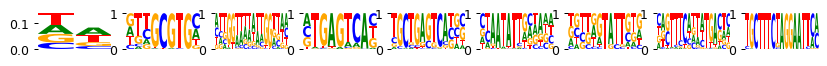

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels 0-69, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 10 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [36:40<00:00, 220.07s/it]


Current time: 2024-07-19 04:42:06.862037
	Loss: 376.356 , R2: 0.798
	Training time (model/function): (2204.442s / 2204.442s)
		per epoch (model/function): (244.938s/ 244.938s)
		per 1k samples: 13.219s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.999681474659403, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 70

### next filter to optimize 70 

FREEZING KERNELS
optimizing feature type mono
next kernels 70-139, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:13:04<00:00, 219.24s/it]


Current time: 2024-07-19 05:56:58.803693
	Loss: 370.796 , R2: 0.799
	Training time (model/function): (6592.207s / 4387.766s)
		per epoch (model/function): (346.958s/ 230.935s)
		per 1k samples: 12.463s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.999681474659403, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:13:21<00:00, 220.07s/it]


Current time: 2024-07-19 07:12:09.138055
	Loss: 142.681 , R2: 0.799
	Training time (model/function): (10996.593s / 4404.385s)
		per epoch (model/function): (578.768s/ 231.810s)
		per 1k samples: 12.511s
best loss 142.644
last five r2 values, by sequential filter optimization: ['0.798']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.999681474659403, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 140

### next filter to optimize 140 

FREEZING KERNELS
optimizing feature type mono
next kernels 140-209, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:13:06<00:00, 219.33s/it]


Current time: 2024-07-19 08:28:49.763828
	Loss: 370.719 , R2: 0.798
	Training time (model/function): (15386.160s / 4389.567s)
		per epoch (model/function): (809.798s/ 231.030s)
		per 1k samples: 12.469s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.999681474659403, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 12/20 [44:00<29:20, 220.08s/it]

In [109]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 10
n_epochs_kernel = 20
log_each=75
n_unfreeze_kernels=70

for optimize_log_dynamic in [True, False]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           use_conv1d=True,
                                           device=device,
                                           p_dropout=0.8,
                                           prepare_knn=optimize_log_dynamic,
                                           knn_free_weights=False,
                                           adata=None if not optimize_log_dynamic else ad,
                                           dinuc_mode=None) # .cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(pwms):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float).squeeze(1))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1,
                                                n_unfreeze_kernels=n_unfreeze_kernels,
                                                # optimiser=topti.SGD,
                                                optimiser=topti.Adam,
                                                # skip_kernels=list(range(1, 2)) + list(range(5, 500)),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=log_each, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

In [ ]:
lib_sizes = train.dataset.rounds.sum(axis=0).flatten()

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
for use_logdynamic in [False, True]:
    p = 'neuroorganoids_use_logdynamic_%i_obs%i.pth' % (use_logdynamic, ad.shape[0])
    print(os.path.exists(p), p)
    torch.save(model_by_logdynamic[use_logdynamic], p)

True neuroorganoids_use_logdynamic_0_obs1646.pth
False neuroorganoids_use_logdynamic_1_obs1646.pth


In [ ]:
ad.shape

(1646, 19883)

In [ ]:
ad.write('neuroorganoids_sample_train_obs%i.h5ad' % ad.shape[0])

In [ ]:
import pickle
pickle.dump(train, open('neuroorganoids_train_dataloader_obs%i.pkl' % ad.shape[0], 'wb'))